In [1]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [2]:
try:
  import transformers
except:
  print('Installing Transformers')
  !pip -q install transformers

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset , DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertConfig, BertTokenizer, BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import ipywidgets as widgets
import os
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi

In [ ]:
try:
  import opendatasets as od
except:
  print('Installing OpenDataSets')
  !pip -q install opendatasets

Installing OpenDataSets


In [5]:
path_cola_out_of_domain_test = 'https://www.kaggle.com/c/cola-out-of-domain-open-evaluation/data'
path_cola_in_domain_test = 'https://www.kaggle.com/c/cola-in-domain-open-evaluation/data'
dir_path = './data'

if not os.path.exists(dir_path) :
  os.makedirs(dir_path)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1072k      0 --:--:-- --:--:-- --:--:-- 1073k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k


In [ ]:
od.download(path_cola_out_of_domain_test, data_dir='./data')
od.download(path_cola_in_domain_test, data_dir='./data')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0  96289      0 --:--:-- --:--:-- --:--:-- 96630


In [ ]:
df = pd.read_csv('/content/data/in_domain_train.tsv', delimiter='\t', header=None, names=['sentence_source', 'label','label_notes', 'sentence'])
df.shape

(8551, 4)

In [ ]:
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .


In [ ]:
sentences = df.sentence.values
sentences = [ '[CLS] ' + sentence + ' [SEP]' for sentence in sentences]
labels = df.label.values

In [ ]:
try:
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
except Exception as e:
  print("An error occurred while downloading the tokenizer.")
  print(str(e))
  import traceback
  print(traceback.format_exc())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenized_texts = [tokenizer.tokenize(sentence) for sentence in sentences]
print('Tokenized First sentence')
print(tokenized_texts[0])

Tokenized First sentence
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [ ]:
# Processing the data
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', padding='post', truncating='post')

In [ ]:
# Create the attention masks
attention_masks = []

for id in input_ids:
  mask = [float(x > 0) for x in id]
  attention_masks.append(mask)

In [ ]:
print(input_ids[0])
print(attention_masks[0])

[  101  2256  2814 24185  1050  1005  1056  4965  2023  4106  1010  2292
  2894  1996  2279  2028  2057 16599  1012   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=.1, random_state=1028)
train_masks, val_masks, _, _ =train_test_split(attention_masks, input_ids, test_size=.1, random_state=1028)

In [ ]:
# create the torch tensor for training
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_labels, train_masks)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_labels, val_masks)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)


In [ ]:
configuration = BertConfig()
model = BertModel(config=configuration)

configuration = model.config
print(configuration)


BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = nn.DataParallel(model)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [ ]:
param_optimizers = list(model.named_parameters())
no_decay = ['bias','LayerNorm.weight']

In [ ]:
optimizer_grouped_parameters = [
    {
    'params': [p for n,p in param_optimizers if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.1
    },
    {
    'params': [p for n,p in param_optimizers if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0
    }

]

In [ ]:
optimizer_grouped_parameters

[{'params': [Parameter containing:
   tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
           [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
           [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
           ...,
           [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
           [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
           [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
          device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
             6.8312e-04,  1.5441e-02],
           [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
             2.9753e-02, -5.3247e-03],
           [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
             1.8741e-02, -7.3140e-03],
           ...,
           [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
             4.3435e-04,

In [ ]:
#Hyperparameters for the training loops
EPOCHS = 4
LEARNING_RATE = 2e-5
EPSILON = 1e-8

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, eps=EPSILON)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_training_steps= total_steps, num_warmup_steps= 0)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def accuracy(preds, actual):
  preds = np.argmax(preds, axis=1)
  actual = actual

  return np.sum(preds == actual) / len(actual)

In [ ]:
# Training loop
train_loss_set = []

for _ in trange(0, EPOCHS, desc='epochs'):
  model.train()

  train_loss, nb_tr_examples,  nb_tr_steps = 0, 0, 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_labels, b_input_masks = batch

    optimizer.zero_grad()

    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_masks, labels=b_input_labels)
    loss = outputs['loss']

    train_loss_set.append(loss.item())

    # backpropogation
    loss.backward()

    # update weights
    optimizer.step()

    # update scheduler
    scheduler.step()

    train_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    #print('nb_tr_examples:', nb_tr_examples)
    nb_tr_steps += 1

  print("Train loss: {}".format(train_loss/nb_tr_steps))

  # evalution
  model.eval()

  eval_loss, eval_accuracy, nb_eval_example, nb_eval_steps = 0, 0, 0, 0

  for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_labels, b_input_masks = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_masks, labels=b_input_labels)

      # move logits and labels to cpu
    logits = outputs['logits'].detach().cpu().numpy()
    labels_id = b_input_labels.to('cpu').numpy()

    tem_eval_accuracy = accuracy(logits, labels_id)
    eval_accuracy += tem_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4999796515678469


epochs:  25%|██▌       | 1/4 [02:38<07:56, 158.68s/it]

Validation Accuracy: 0.8209876543209877
Train loss: 0.3146339543318353


epochs:  50%|█████     | 2/4 [05:18<05:19, 159.64s/it]

Validation Accuracy: 0.8171296296296297
Train loss: 0.18925923263630925


epochs:  75%|███████▌  | 3/4 [07:59<02:40, 160.11s/it]

Validation Accuracy: 0.8348765432098766
Train loss: 0.12094962193449009


epochs: 100%|██████████| 4/4 [10:40<00:00, 160.00s/it]

Validation Accuracy: 0.8383487654320988


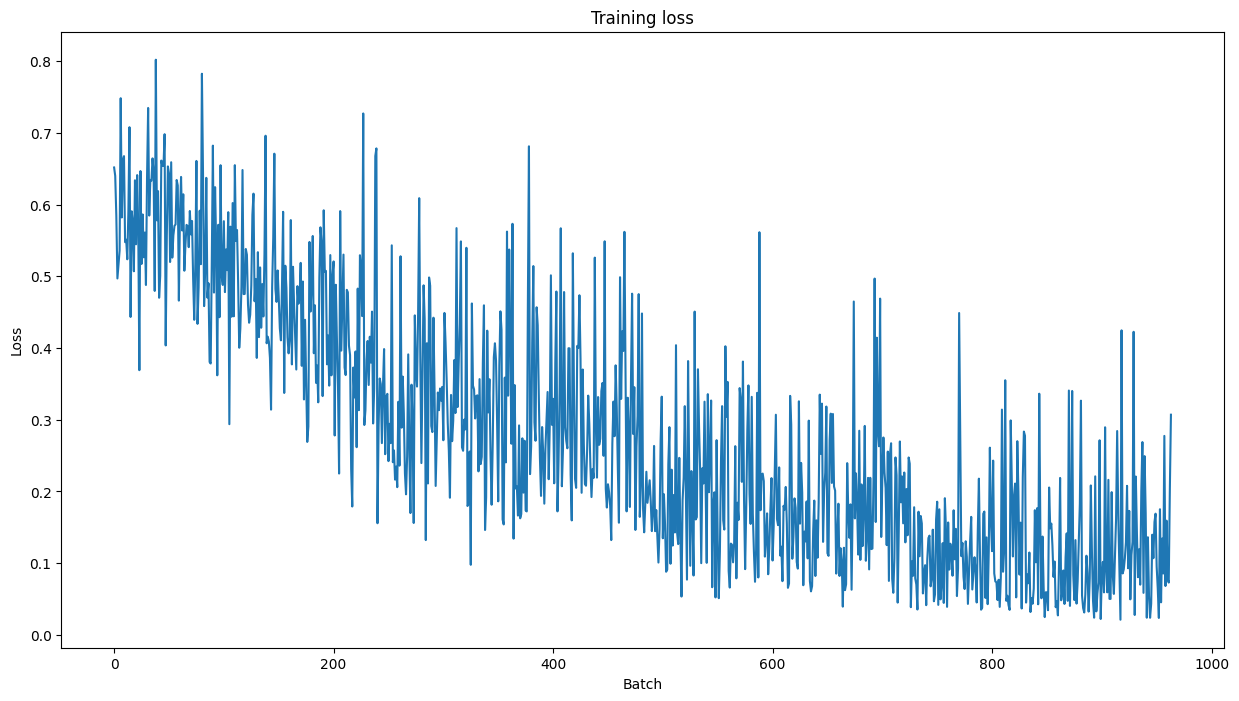

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


In [ ]:
df = pd.read_csv('/content/data/out_of_domain_dev.tsv', delimiter='\t', header=None, names=['sentence_source', 'label','label_notes', 'sentence'])
df.shape

(516, 4)

In [ ]:
df.head()

,sentence_source,label,label_notes,sentence
0,clc95,1,NaN,somebody just left - guess who .
1,clc95,1,NaN,"they claimed they had settled on something , b..."
2,clc95,1,NaN,"if sam was going , sally would know where ."
3,clc95,1,NaN,"they 're going to serve the guests something ,..."
4,clc95,1,NaN,she 's reading . i ca n't imagine what .


In [ ]:
sentences = df.sentence.values
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]
labels = df.label.values


In [ ]:
sentences[1]

"[CLS] they claimed they had settled on something , but it was n't clear what they had settled on . [SEP]"

In [ ]:
tokenized_texts = [tokenizer.tokenize(sentence) for sentence in sentences]

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

In [ ]:
attention_masks = []
for seq in input_ids:
  mask = [float(i > 0) for i in seq]
  attention_masks.append(mask)


In [ ]:
print(input_ids[0])
print(attention_masks[0])

[ 101 8307 2074 2187 1011 3984 2040 1012  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
pred_input_ids = torch.tensor(input_ids)
pred_labels = torch.tensor(labels)
pred_masks = torch.tensor(attention_masks)

In [ ]:
pred_data = TensorDataset(pred_input_ids, pred_labels, pred_masks)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=BATCH_SIZE)

In [ ]:
raw_pred, pred_classes, true_labels = [], [], []

for batch in pred_dataloader:
   batch = tuple(t.to(device) for t in batch)
   b_input_ids, b_labels, b_masks = batch
   with torch.no_grad():
    output = model(b_input_ids, token_type_ids=None, attention_mask=b_masks)
    #print('Model Output: ', output)
   logits = output['logits'].detach().to('cpu').numpy()
   labels_id = b_labels.to('cpu').numpy()



   b_input_ids = b_input_ids.to('cpu').numpy()

   batch_sentences = [tokenizer.decode(b_input_id, skip_special_tokens=True) for b_input_id in b_input_ids]

   probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

   batch_pred = np.argmax(probabilities, axis=1)

   for i, sentence in enumerate(batch_sentences):
    print(f'Sentence: {sentence}')
    print(f'Prediction: {logits[i]}')
    print(f'probability: {probabilities[i]}')
    print(f'Actual label: {labels_id[i]}')
    print(f'Predicted labels: {batch_pred[i]}')


   raw_pred.append(logits)
   pred_classes.append(batch_pred)
   true_labels.append(labels_id)



Sentence: somebody just left - guess who.
Prediction: [-2.423784   2.5442758]
probability: tensor([0.0069, 0.9931])
Actual label: 1
Predicted labels: 1
Sentence: they claimed they had settled on something, but it wasn't clear what they had settled on.
Prediction: [-2.2987967  2.4171305]
probability: tensor([0.0089, 0.9911])
Actual label: 1
Predicted labels: 1
Sentence: if sam was going, sally would know where.
Prediction: [-2.4342558  2.4781153]
probability: tensor([0.0073, 0.9927])
Actual label: 1
Predicted labels: 1
Sentence: they're going to serve the guests something, but it's unclear what.
Prediction: [-2.370446   2.6178691]
probability: tensor([0.0068, 0.9932])
Actual label: 1
Predicted labels: 1
Sentence: she's reading. i can't imagine what.
Prediction: [-1.990829   1.9129004]
probability: tensor([0.0198, 0.9802])
Actual label: 1
Predicted labels: 1
Sentence: john said joan saw someone from her graduating class.
Prediction: [-2.5937304  2.717753 ]
probability: tensor([0.0049, 0.

In [ ]:
matthews_corrcoef_set = []

for index in range(len(true_labels)):
  corr_coef = matthews_corrcoef(true_labels[index], pred_classes[index])
  matthews_corrcoef_set.append(corr_coef)




In [ ]:
matthews_corrcoef_set

[0.049286405809014416,
 -0.21684543705982773,
 0.4732058754737091,
 0.34151450937027694,
 0.44440090347500916,
 0.7410010097502685,
 0.5204358386562267,
 0.47519096331149147,
 0.9165151389911681,
 0.7177405625652734,
 0.9229582069908973,
 0.8320502943378436,
 0.8150678894028793,
 0.647150228929434,
 0.3268228676411533,
 0.6625413488689132,
 -0.3333333333333333]

In [6]:
model_save_path = '/content/mydrive/MyDrive/Colab Notebooks/NLP/models'

In [ ]:
#model_save_path = '/content/mydrive/MyDrive/Colab Notebooks/NLP/models'

if not os.path.exists(model_save_path):
  os.makedirs(model_save_path)

if isinstance(model, torch.nn.DataParallel):
  model.module.save_pretrained(model_save_path)
else:
  model.save_pretrained(model_save_path)


tokenizer.save_pretrained(model_save_path)

('/content/mydrive/MyDrive/Colab Notebooks/NLP/models/tokenizer_config.json',
 '/content/mydrive/MyDrive/Colab Notebooks/NLP/models/special_tokens_map.json',
 '/content/mydrive/MyDrive/Colab Notebooks/NLP/models/vocab.txt',
 '/content/mydrive/MyDrive/Colab Notebooks/NLP/models/added_tokens.json')

In [7]:
# Inference for the trained model
model = BertForSequenceClassification.from_pretrained(model_save_path)

In [9]:
# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [75]:
# define the inference method:
def inference(model, tokenizer, sentence):
  sentence = '[CLS] ' + sentence + ' [SEP]'
  tokenized_text = tokenizer.tokenize(sentence)

  input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
  segmented_ids = [0] * len(tokenized_text)

  #print('input_ids:',input_ids)
  #print('segmented_ids:',segmented_ids)

  input_ids = torch.tensor([input_ids])
  segmented_ids = torch.tensor([segmented_ids])

  with torch.no_grad():

    output = model(input_ids, token_type_ids= segmented_ids)

    logits = output['logits'].detach().to('cpu').numpy()
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)
    prediction = np.argmax(logits, axis=1)

  return prediction

In [70]:
#sentence = 'They go no market.'
#output = model_predict_interface(sentence)

input_ids: tensor([[ 101, 2027, 2175, 2053, 3006, 1012,  102]])


In [78]:
text_input = widgets.Textarea(
    placeholder='Type something',
    description='Sentence:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='50px')
)

output_label = widgets.Label(
    value='',
    layout=widgets.Layout(width='100%', height='25px'),  # Adjust width and height here
    style={'description_width': 'initial'}
)

def model_predict_interface(sentence):
    prediction = inference(model, tokenizer, sentence)
    if prediction == 0:
        return "Grammatically Incorrect"
    elif prediction == 1:
        return "Grammatically Correct"
    else:
        return f"Label: {prediction}"



def on_text_submit(change):
  output_label.value = model_predict_interface(change.new)

text_input.observe(on_text_submit, names='value')
display(text_input,output_label)

Textarea(value='', description='Sentence:', layout=Layout(height='50px', width='100%'), placeholder='Type some…

Label(value='', layout=Layout(height='25px', width='100%'), style=DescriptionStyle(description_width='initial'…